In [33]:
"""
This is a the shrinkage version of Transport map. In this version, 
the regression functions $f_i$ and the niggest parameters $d_i$ are 
assumed to have some specific structures. These values are given by
the parametric covariance matrix. At the time being, no estimation
of the parametric covariance matrix is considered. In other words, 
we imply that all the parameters of the parametric covariance matrix
are known and does not need to be estimated. In latter versions, we
will consider the estimation of the parametric covariance matrix.


Author: Anirban Chakraborty,
Last modified: May 4, 2024
"""
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load necessary libraries

In [34]:
import torch
import numpy as np
from veccs import orderings
from gpytorch.kernels import MaternKernel
from sklearn.gaussian_process import kernels
from matplotlib import pyplot as plt

from batram.helpers import make_grid, GaussianProcessGenerator
from batram.legmods import Data, SimpleTM
from batram.shrinkmods import ShrinkTM


### Sample initial data

In [35]:
num_locs = 30; dim_locs = 2
nu_original = 0.6
length_scale_original = 0.3
numSamples = 30
sd_noise=1e-3

In [36]:
locs = make_grid(num_locs, dim_locs)
locsOriginal = make_grid(num_locs, dim_locs) #so that later ordering does not hurt

#sample data
gpkernel = kernels.Matern(nu=nu_original, length_scale=length_scale_original)
gp = GaussianProcessGenerator(locs=locs, kernel=gpkernel, sd_noise=sd_noise)
numpydata = gp.sample(num_reps=200)

### Plot sampled data

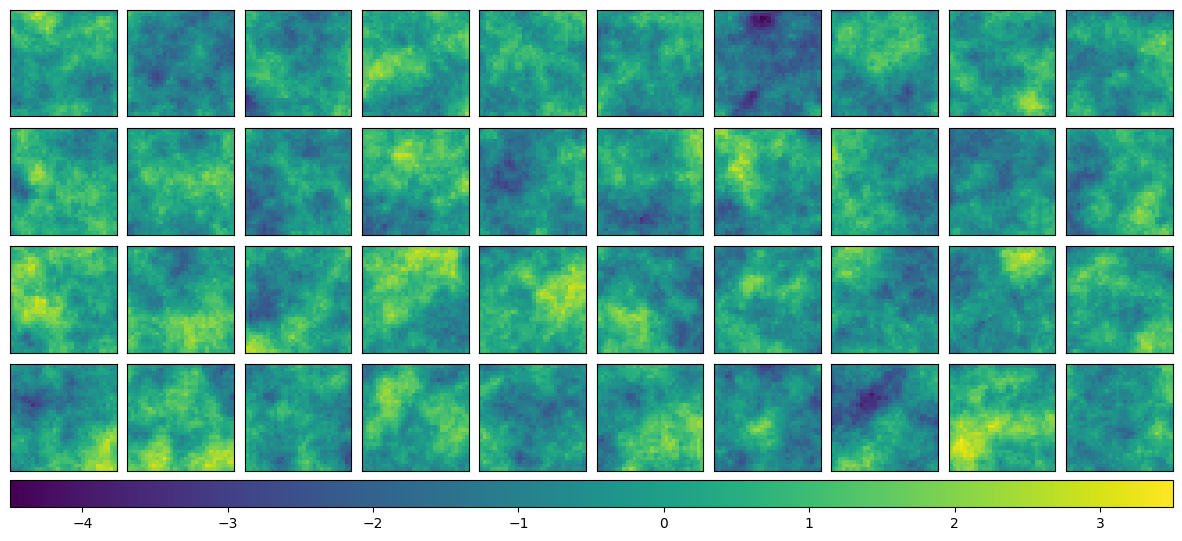

In [37]:
gspec = {"wspace": 0.1, "hspace": 0.1}
fig, ax = plt.subplots(4, 10, figsize=(15, 6), gridspec_kw=gspec, squeeze=True)
vmin, vmax = numpydata[:40].min(), numpydata[:40].max()
for i in range(40):
    _ = ax[i // 10, i % 10]
    im = _.imshow(numpydata[i].reshape(num_locs, num_locs), vmin=vmin, vmax=vmax)
    _.set_xticks([])
    _.set_yticks([])
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.125, 0.05, 0.775, 0.045])
fig.colorbar(im, cax=cbar, orientation="horizontal")
plt.show()

### Preprocess sampled data

In [38]:
torchdata = torch.from_numpy(numpydata).float() #converts into torch format
locsorder = orderings.maxmin_cpp(locs=locs) #find maxmin-ordeing

obs = torchdata[0:25, :] #snip first 15 samples
obs = obs - obs.mean(dim=0, keepdim=True) #pixel-wise centering the data
obsTrain = obs
locs = locs[locsorder, ...]
obs = obs[..., locsorder]


largest_conditioning_set = 30
nn = orderings.find_nns_l2(locs, largest_conditioning_set)

# Create a `Data` object for use with the `SimpleTM`/ `ShrinkTM` model.
data = Data.new(torch.as_tensor(locs).float(), obs, torch.as_tensor(nn))


### Fitting the SimpleTM first (to see the results)

In [8]:
tm = SimpleTM(data, theta_init=None, linear=False, smooth=1.5, nug_mult=4.0)
nsteps = 200
opt = torch.optim.Adam(tm.parameters(), lr=0.01)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, nsteps)
res = tm.fit(
    nsteps, 0.1, test_data=tm.data, optimizer=opt, scheduler=sched, batch_size=128
)

Train Loss: -11702.192, Test Loss: -11699.458: 100%|██████████| 200/200 [00:13<00:00, 14.65it/s]


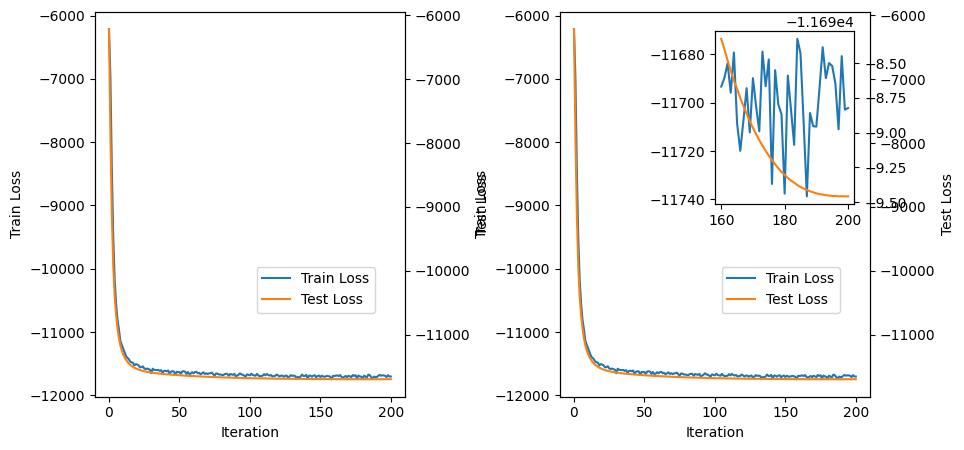

In [9]:
# The `plot_loss` method optionally allows plotting the loss using an inset. The
# inset is useful for visualizing the loss near convergence. It plots the last
# 20% of the loss values when building the inset.
fig, axs = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"wspace": 0.5})
res.plot_loss(axs[0], use_inset=False)
res.plot_loss(axs[1], use_inset=True)
plt.show()

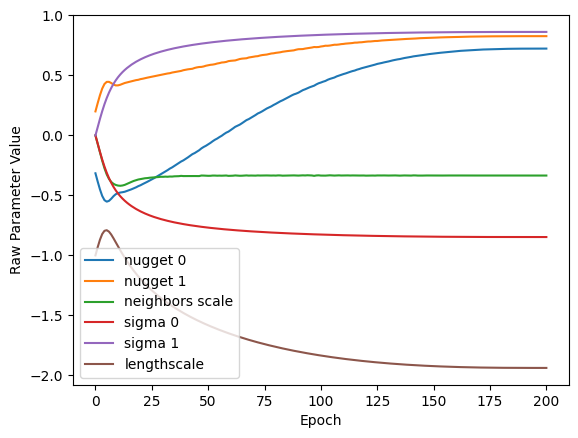

In [10]:
res.plot_params()
plt.show()

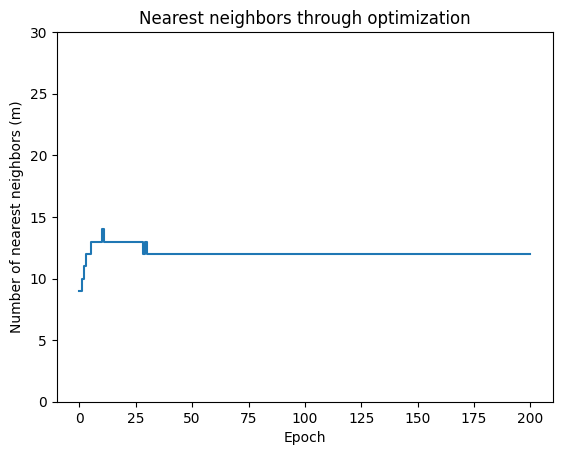

In [11]:
res.plot_neighbors()
plt.show()

In [12]:
new_sample = tm.cond_sample()[0, ...]

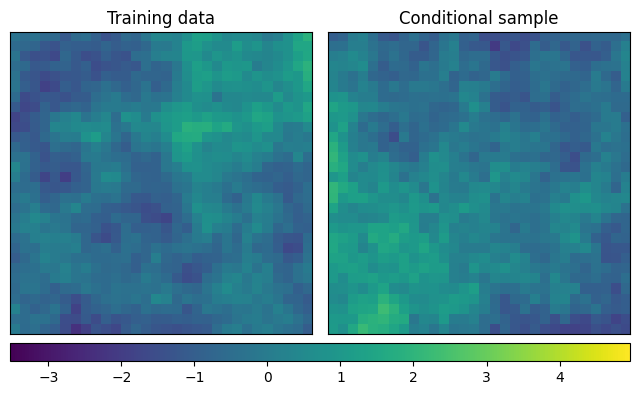

In [13]:
# Compare the resampled field with the training data
vmin, vmax = obs[:40].min(), obs[:40].max()
gspec = {"wspace": 0.05}
fig, ax = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=gspec, squeeze=True)

# Plot the training data
ax[0].imshow(obs[0, locsorder.argsort()].reshape(num_locs, num_locs), vmin=vmin, vmax=vmax)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("Training data")


# Plot the conditionally resampled field (sample 2)
im = ax[1].imshow(new_sample[locsorder.argsort()].reshape(num_locs, num_locs), vmin=vmin, vmax=vmax)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("Conditional sample")

fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.125, 0.05, 0.775, 0.045])
fig.colorbar(im, cax=cbar, orientation="horizontal")
plt.show()

### Calculate conditional means and variances for the parametric kernel (this would change in latter versions)

In [39]:
parametric_mean_factors = torch.zeros((locs.shape[0], (data.augmented_response.shape[-1]-1)))
parametric_variances = torch.zeros(locs.shape[0])
parametric_variances[0] = 1

for i in range(1, locs.shape[0]):
    current_locs = locs[i, :]
    if i < largest_conditioning_set:
        previous_locs = locs[nn[i, 0:i], :]
    else:
        previous_locs = locs[nn[i], :]
    Sigma22 = torch.from_numpy(gpkernel(previous_locs, previous_locs)) + (sd_noise ** 2) * torch.eye(previous_locs.shape[0])
    Sigma12 = torch.from_numpy(gpkernel(current_locs, previous_locs))
    Sigma22inv = torch.linalg.solve(Sigma22, torch.eye(previous_locs.shape[0], dtype=torch.double))
    parametric_mean_factors[i, 0:min(i, largest_conditioning_set)] = Sigma12 @ Sigma22inv
    parametric_variances[i] = 1 - Sigma12 @ Sigma22inv @ Sigma12.T

### Fitting the shrinkage TM

In [40]:
shrink_tm = ShrinkTM(data, theta_init=None, linear=False, 
                     smooth=1.5, 
                     shrinkage_mean_factor=parametric_mean_factors,
                     shrinkage_var=parametric_variances)

In [41]:
nsteps = 200
opt = torch.optim.Adam(tm.parameters(), lr=0.01)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, nsteps)
res = shrink_tm.fit(
    nsteps, 0.1, test_data=tm.data, optimizer=opt, scheduler=sched, batch_size=128
)

Train Loss: -11153.152, Test Loss: 22128.279: 100%|██████████| 200/200 [00:13<00:00, 14.96it/s]


In [44]:
shrink_tm._parameters

TypeError: 'collections.OrderedDict' object is not callable